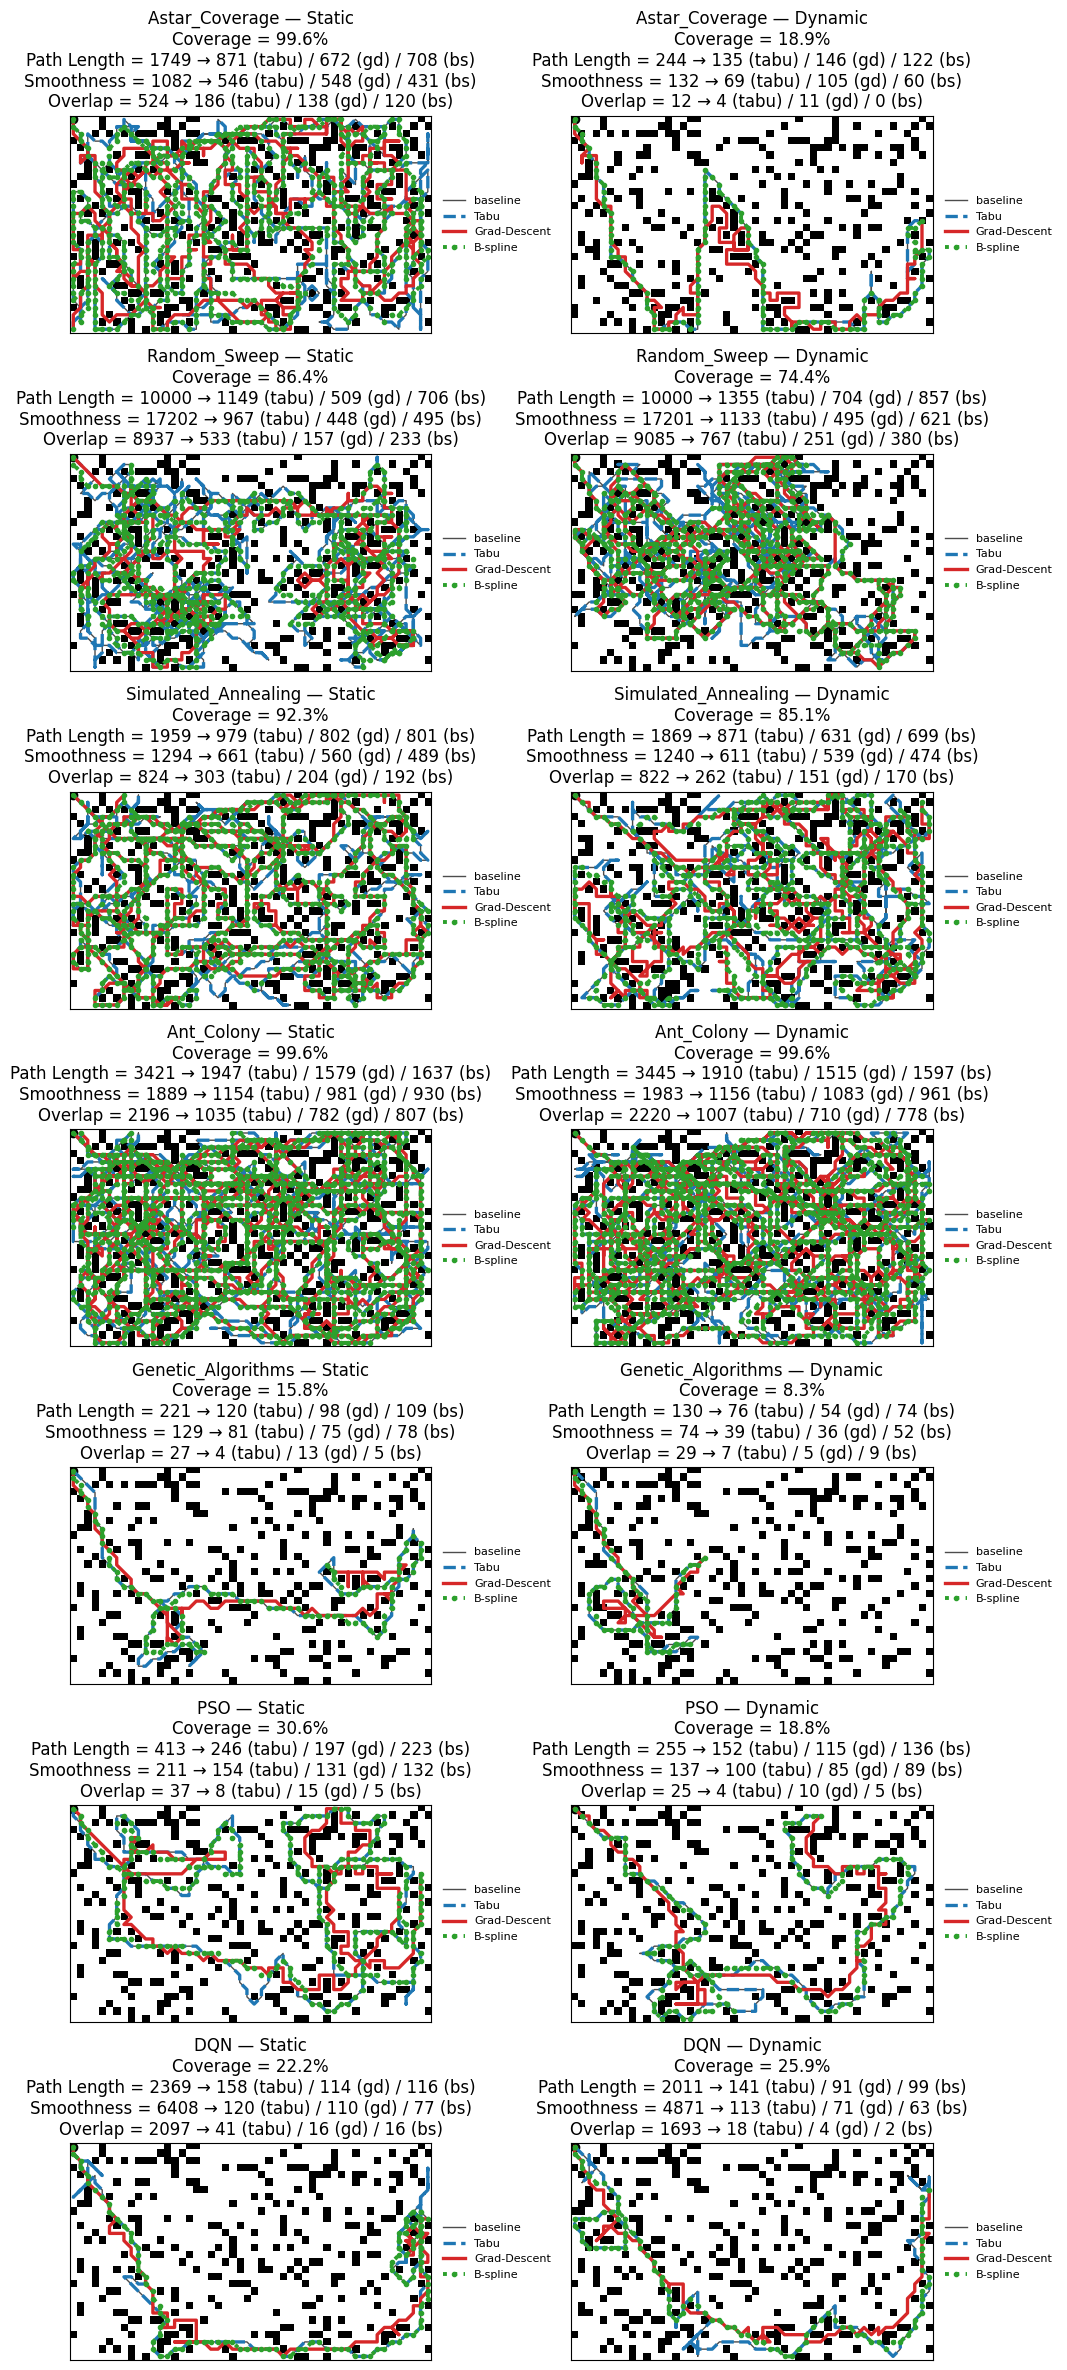


=== Static Results ===
Astar_Coverage         | Coverage= 99.59% | PathLength= 1749 | Overlap=  524 | Time= 0.067s | Energy=  1749
Random_Sweep           | Coverage= 86.43% | PathLength=10000 | Overlap= 8937 | Time= 0.044s | Energy= 10000
Simulated_Annealing    | Coverage= 92.28% | PathLength= 1959 | Overlap=  824 | Time= 5.001s | Energy=  1959
Ant_Colony             | Coverage= 99.59% | PathLength= 3421 | Overlap= 2196 | Time= 5.004s | Energy=  3421
Genetic_Algorithms     | Coverage= 15.84% | PathLength=  221 | Overlap=   27 | Time= 5.038s | Energy=   221
PSO                    | Coverage= 30.63% | PathLength=  413 | Overlap=   37 | Time= 5.053s | Energy=   413
DQN                    | Coverage= 22.18% | PathLength= 2369 | Overlap= 2097 | Time= 5.000s | Energy=  2369

=== Dynamic Results ===
Astar_Coverage         | Coverage= 18.93% | PathLength=  244 | Overlap=   12 | Time= 0.012s | Energy=   244
Random_Sweep           | Coverage= 74.41% | PathLength=10000 | Overlap= 9085 | Time= 0.

In [4]:
import math
import random
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Set, Dict, Deque
import heapq
from collections import deque
# For Grid Representation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Globals

Coord = Tuple[int, int]
DYNAMIC_MOVE_PER_STEP = False   # How often cells move
COVERAGE_FINAL_STATE  = False   # Measures how much the the drone explored

# ----------GridWorld Class (The 2D Environment)----------

@dataclass
class GridWorld:
  width: int
  height: int
  ObstacleRatio: float = 0.15 # percentage of cells randomly set as static objects
  seed: int = 0
  DynamicObstacles: int = 0 # Number of moving obstacles
  DynamicMove_Prob: float = 0.2 # Probability that the object moves
  grid: np.ndarray = field(init=False)
  DynamicPositions: List[Coord] = field(default_factory=list) # List of Coordinates for dynamic obstacles

  # cached static mask / list of free cells
  static_free_mask: np.ndarray = field(init=False, repr=False)
  free_cells: List[Coord] = field(init=False, repr=False)

  # Creating Random Static Obstacles
  def __post_init__(self):
    RNG = random.Random(self.seed)
    self.grid = np.zeros((self.height, self.width), dtype=np.uint8)
    # Static obstacles
    NumberOf_Obstacles = int(self.width * self.height * self.ObstacleRatio)
    placed = 0
    while placed < NumberOf_Obstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0: # free
        self.grid[r, c] = 1  # static obstacle
        placed += 1

    self.grid[0, 0] = 0 # Start cell is always free

    # Dynamic obstacles
    self.DynamicPositions = []
    while len(self.DynamicPositions) < self.DynamicObstacles:
      r, c = RNG.randrange(self.height), RNG.randrange(self.width)
      if self.grid[r, c] == 0 and (r, c) not in self.DynamicPositions and (r, c) != (0,0):
        self.DynamicPositions.append((r,c))

    # Precompute static free space once (IMPROVEMENT)
    self.static_free_mask = (self.grid == 0)
    self.free_cells = [(r, c) for r in range(self.height) for c in range(self.width) if self.grid[r, c] == 0]

    # Coverage mode: no fixed goal
    self.Goal = None

  # Check if Coordinate is inside the grid
  def InBounds(self, p: Coord) -> bool:
    r, c = p
    return 0 <= r < self.height and 0 <= c < self.width

  # Checks if a cell is not an obstacle (dynamic or otherwise)
  def IsFree(self, p: Coord) -> bool:
    r, c = p
    if not self.InBounds(p):
      return False
    if self.grid[r, c] == 1:
      return False
    if p in self.DynamicPositions:
      return False
    return True

  # Returns the 4-connected neighbours (up, down left, right)
  def neighbors4(self, p: Coord) -> List[Coord]:
    r, c = p
    neighbor = [(r+1, c), (r-1, c), (r, c+1), (r, c-1)]
    return [q for q in neighbor if self.InBounds(q)]

  # Moves each dynamic obstacle randomly to an adjacent free cell with DynamicMove_Prob
  def StepForDynamic(self, RNG: random.Random):
    # FIX: prevent two obstacles taking the same new cell in the same tick
    NewPositions = []
    old = set(self.DynamicPositions)
    taken = set()  # reserve new cells this tick
    for position in self.DynamicPositions:
        newpos = position
        if RNG.random() < self.DynamicMove_Prob:
            candidates = [q for q in self.neighbors4(position)
                          if self.grid[q] == 0
                          and q not in old        # not someone’s old spot
                          and q not in taken      # not already taken this tick
                          and q != (0, 0)         # don't sit on start
            ]
            if candidates:
                newpos = RNG.choice(candidates)
        NewPositions.append(newpos)
        taken.add(newpos)
    self.DynamicPositions = NewPositions


# --------- UAV Agent ---------------

# Represents the UAV
# Each move costs MoveCost Energy, and stops when BatteryCapacity is reached
@dataclass
class Agent:
  start: Coord = (0, 0)
  BatteryCapacity: int = 10_000 # Amount of "Energy units"
  MoveCost: int = 1
  path: List[Coord] = field(default_factory=lambda: [(0,0)])
  EnergyUsed: int = 0
# Returns the current positions
  def at(self) -> Coord:
    return self.path[-1]

# Checks if the agent still has enegry
  def CanMove(self) -> bool:
    return (self.EnergyUsed + self.MoveCost) <= self.BatteryCapacity

# Moves the UAV to the next cell, then updates the path and energy used
  def MoveTo(self, p:Coord):
    self.path.append(p)
    self.EnergyUsed += self.MoveCost

# Holds the performance data for a single simulation
@dataclass
class RunMetrics:
  CoveragePercentage: float # CoveragePercentage
  PathLength: int # Path Length
  OverlapCount: int # Overlap Count
  ExecutionTime: float # Execution Time
  EnergyUsed: int # Energy Used


# ----------- Path Finding Utilities -------------

def manhattan(a: Coord, b: Coord) -> int:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


# Part of Astar search, it's job is to rebuild the path from the start cell to the goal cell (lists path from start cell to goal cell)
def Rebuild_Path(From: Dict[Coord, Coord], goal: Coord) -> List[Coord]:
    current = goal
    rev = [current]
    while current in From:
        current = From[current]
        rev.append(current)
    rev.reverse()
    return rev


def Astar(grid: GridWorld, start: Coord, goal: Coord) -> Optional[List[Coord]]:
    if not grid.IsFree(start) or not grid.IsFree(goal):
        return None
    openh = []
    heapq.heappush(openh, (0 + manhattan(start, goal), 0, start))
    From: Dict[Coord, Coord] = {}
    g = {start: 0}
    visited = set()
    while openh:
        f, cost, current = heapq.heappop(openh)
        if current == goal:
            return Rebuild_Path(From, current)
        if current in visited:
            continue
        visited.add(current)
        for nb in grid.neighbors4(current):
            if not grid.IsFree(nb):
                continue
            newg = cost + 1
            if nb not in g or newg < g[nb]:
                g[nb] = newg
                From[nb] = current
                heapq.heappush(openh, (newg + manhattan(nb, goal), newg, nb))
    return None

# ------- DQN helpers ------

ACTIONS_4 = [(1,0), (-1,0), (0,1), (0,-1)] #  2D actions - UP, DOWN, RIGHT, LEFT

# Extract a small square area around the UAV
def extract_local_observation(world: GridWorld, position: Coord, dynamic:bool, radius: int = 3) -> np.ndarray:

    patch = np.ones((2 * radius + 1, 2 * radius + 1), dtype=np.float32)
    H, W = world.height, world.width
    pr, pc = position

    for dr in range(-radius, radius + 1):
        for dc in range(-radius, radius + 1):
            r, c = pr + dr, pc + dc
            if 0 <= r < H and 0 <= c < W:
                free = (world.grid[r, c] == 0)
                if dynamic and (r, c) in world.DynamicPositions:
                    free = False
                patch[dr + radius, dc + radius] = 0.0 if free else 1.0
    return patch.flatten()


def move_in_direction(world: GridWorld, current: Coord, action_index: int) -> Coord:
    """
    Apply an action to move the UAV in one of 4 directions.
    If the target cell is blocked, stay in place.
    """
    dr, dc = ACTIONS_4[action_index]
    next_pos = (current[0] + dr, current[1] + dc)
    if world.InBounds(next_pos) and world.IsFree(next_pos):
        return next_pos
    return current


def valid_action_indices(world: GridWorld, pos: Coord) -> List[int]:
    """Return indices of actions that lead to a free, in-bounds neighbor."""
    val = []
    r, c = pos
    for idx, (dr, dc) in enumerate(ACTIONS_4):
        nr, nc = r + dr, c + dc
        if world.InBounds((nr, nc)) and world.IsFree((nr, nc)):
            val.append(idx)
    return val

def choose_masked_greedy(policy, device, state_vec: np.ndarray, valid_idxs: List[int]) -> int:
    """Greedy action with invalid actions masked to -inf."""
    with torch.no_grad():
        s = torch.from_numpy(state_vec).float().unsqueeze(0).to(device)  # [1, D]
        q = policy(s).squeeze(0)                                         # [4]
        if not valid_idxs:
            # no valid moves (boxed in) → pick any (will result in staying)
            return int(torch.argmax(q).item())
        mask = torch.full_like(q, float('-inf'))
        mask[valid_idxs] = 0.0
        masked_q = q + mask
        return int(torch.argmax(masked_q).item())



# Helpers (stay inside visited/allowed sets)

def _visited_from_path(path: List[Coord]) -> Set[Coord]:
    return set(path)

def AstarRestricted(grid: GridWorld, start: Coord, goal: Coord, allowed: Optional[Set[Coord]]) -> Optional[List[Coord]]:
    if allowed is None:
        return Astar(grid, start, goal)
    if start not in allowed or goal not in allowed:
        return None
    openh = []
    heapq.heappush(openh, (0 + manhattan(start, goal), 0, start))
    From: Dict[Coord, Coord] = {}
    g = {start: 0}
    visited = set()
    while openh:
        f, cost, current = heapq.heappop(openh)
        if current == goal:
            return Rebuild_Path(From, current)
        if current in visited:
            continue
        visited.add(current)
        for nb in grid.neighbors4(current):
            if nb not in allowed:
                continue
            if not grid.InBounds(nb) or not grid.IsFree(nb):
                continue
            newg = cost + 1
            if nb not in g or newg < g[nb]:
                g[nb] = newg
                From[nb] = current
                heapq.heappush(openh, (newg + manhattan(nb, goal), newg, nb))
    return None

def line_of_sight_restricted(world: GridWorld, a: Coord, b: Coord, allowed: Optional[Set[Coord]]) -> bool:
    """True if every cell on line a->b is free and (if restricted) in 'allowed'."""
    for p in bresenham_line(a, b):
        if not world.InBounds(p) or not world.IsFree(p):
            return False
        if allowed is not None and p not in allowed:
            return False
    return True



def nearest_unvisited_via_bfs(world: GridWorld, start: Coord, visited: Set[Coord],
                              time_budget_s: float = 0.010) -> Optional[Coord]:

    if not world.IsFree(start):
        return None
    t0 = time.perf_counter()
    q: Deque[Coord] = deque([start])
    seen: Set[Coord] = {start}
    while q:
        if time.perf_counter() - t0 > time_budget_s:
            break  # respect tiny time budget to stay responsive
        u = q.popleft()
        if u not in visited:
            # Return the first unvisited cell found (closest by BFS metric)
            return u
        for nb in world.neighbors4(u):
            if nb in seen:
                continue
            if world.IsFree(nb):
                seen.add(nb)
                q.append(nb)
    return None


# ------------------ Coverage Algorithms -------------------------

def _follow_path_with_dynamic(world: GridWorld, agent: Agent, path: List[Coord],
                              RNG: random.Random, dynamic: bool,
                              replan_goal: Optional[Coord],
                              max_replans: int = 2) -> Tuple[int, int]:

    steps_taken = 0
    overlap = 0
    i = 1  # start from first move
    replans = 0
    while i < len(path) and agent.CanMove():
        if dynamic and DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        nxt = path[i]
        if dynamic and not world.IsFree(nxt):
            # blocked by mover — try quick replan to the same goal
            if replan_goal is None or replans >= max_replans:
                break
            new_path = Astar(world, agent.at(), replan_goal)
            replans += 1
            if not new_path or len(new_path) < 2:
                break
            path = new_path
            i = 1
            continue

        if nxt in agent.path:
            overlap += 1
        agent.MoveTo(nxt)
        steps_taken += 1
        i += 1
    return steps_taken, overlap


# Astar

def Astar_Coverage(world: GridWorld, agent: Agent, seed: int = 0,
                   dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()]) # keeps track of all visited cells
    overlap = 0 # counts revisited cells
    t0 = time.perf_counter() # record start time

    Total_Free = int(world.static_free_mask.sum()) # from cached mask (IMPROVEMENT)

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:  # safety timeout
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        current = agent.at()

        # (IMPROVEMENT) Nearest unvisited via BFS in true grid metric
        goal = nearest_unvisited_via_bfs(world, current, visited)
        if goal is None:
            break

        # If we're already on an unvisited cell (BFS returns current), mark and continue
        if goal == current:
            visited.add(current)
            continue

        path = Astar(world, current, goal)
        if not path:
            # If the nearest unvisited is not reachable, try a couple of alternative BFS samples
            # (bounded attempts to stay fast)
            fallback_tries = 2
            tried = {goal}
            for _ in range(fallback_tries):
                alt = nearest_unvisited_via_bfs(world, current, visited, time_budget_s=0.005)
                if alt is None or alt in tried:
                    continue
                tried.add(alt)
                path = Astar(world, current, alt)
                if path:
                    goal = alt
                    break
            if not path:
                break  # no reachable targets left

        # Follow the path with dynamic-aware quick replans (IMPROVEMENT)
        st_taken, ov_add = _follow_path_with_dynamic(world, agent, path, RNG, dynamic, replan_goal=goal)
        steps += st_taken
        overlap += ov_add

        # record newly visited cells
        for p in agent.path[-st_taken:]:
            visited.add(p)

        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap,
                      t1 - t0, agent.EnergyUsed)


# RandomSweep

def RandomSweep(world: GridWorld, agent: Agent, seed: int = 0,
                dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Total_Free = int(world.static_free_mask.sum())

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        current = agent.at()
        moves = [p for p in world.neighbors4(current) if world.IsFree(p)]
        if not moves:
            break
        nxt = RNG.choice(moves)

        if nxt in visited:
            overlap += 1
        agent.MoveTo(nxt)
        visited.add(nxt)
        steps += 1

        if dynamic and DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed)


# Simulated Annealing

def SimulatedAnnealing(world: GridWorld, agent: Agent, seed: int = 0,
                       dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Total_Free = int(world.static_free_mask.sum())

    steps = 0
    T0, T_min, cooling = 5.0, 0.1, 0.995
    T = T0

    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        current = agent.at()

        # candidate unvisited cells (limit by BFS ring using Manhattan as prefilter is ok here)
        candidates = []
        for (r, c) in world.free_cells:
            if (r, c) not in visited:
                candidates.append((manhattan(current, (r, c)), (r, c)))
        if not candidates:
            break

        candidates.sort(key=lambda x: x[0])
        candidates = candidates[:200]
        dists = [max(1, d) for d, _ in candidates]
        weights = [math.exp(-d / max(T, 1e-6)) for d in dists]
        s = sum(weights)
        probs = [w / s for w in weights] if s > 0 else [1.0/len(weights)]*len(weights)
        rnum = RNG.random()
        cum, goal = 0.0, candidates[0][1]
        for (d, p), pr in zip(candidates, probs):
            cum += pr
            if rnum <= cum:
                goal = p
                break

        path = Astar(world, current, goal)
        if not path:
            T = max(T_min, T * cooling)
            continue

        st_taken, ov_add = _follow_path_with_dynamic(world, agent, path, RNG, dynamic, replan_goal=goal)
        steps += st_taken
        overlap += ov_add
        for p in agent.path[-st_taken:]:
            visited.add(p)

        T = max(T_min, T * cooling)
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed)



# Ant Colony Optimization

def AntColony(world: GridWorld, agent: Agent, seed: int = 0,
              dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Total_Free = int(world.static_free_mask.sum())

    pher = np.full_like(world.grid, 1.0, dtype=float)
    rho, alpha, beta, reward = 0.02, 1.0, 2.0, 5.0

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        current = agent.at()
        cand = []
        for (r, c) in world.free_cells:
            if (r, c) not in visited:
                cand.append((manhattan(current, (r, c)), (r, c)))
        if not cand:
            break
        cand.sort(key=lambda x: x[0])
        cand = cand[:200]

        numer = []
        for d, p in cand:
            d = max(1, d)
            tau = pher[p]
            eta = 1.0 / d
            numer.append((tau ** alpha) * (eta ** beta))
        s = sum(numer)

        goal = cand[0][1]
        if s != 0:
            rnum, cum = RNG.random(), 0.0
            for (d, p), val in zip(cand, numer):
                cum += val / s
                if rnum <= cum:
                    goal = p
                    break

        path = Astar(world, current, goal)
        if not path:
            pher *= (1.0 - rho)
            continue

        newly = 0
        st_taken, ov_add = _follow_path_with_dynamic(world, agent, path, RNG, dynamic, replan_goal=goal)
        for p in agent.path[-st_taken:]:
            if p not in visited:
                newly += 1
        steps += st_taken
        overlap += ov_add
        visited.update(agent.path[-st_taken:])

        pher *= (1.0 - rho)
        if newly > 0:
            pher[goal] += reward * newly
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed)


# Genetic Algorithm

def GeneticAlgorithm(world: GridWorld, agent: Agent, seed: int = 0,
                     dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Total_Free = int(world.static_free_mask.sum())

    def frontier_list(cur: Coord) -> List[Coord]:
        L = []
        for (r, c) in world.free_cells:
            if (r, c) not in visited:
                L.append((manhattan(cur, (r, c)), (r, c)))
        L.sort(key=lambda x: x[0])
        return [p for _, p in L[:300]]

    pop_size, seq_len, cx_rate, mut_rate, gens = 20, 5, 0.7, 0.3, 12
    steps = 0

    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        cur = agent.at()

        fr = frontier_list(cur)
        if not fr:
            break

        def random_seq():
            return [fr[RNG.randrange(len(fr))] for _ in range(seq_len)]

        def fitness(seq):
            pos, length, gain = cur, 0, 0
            for g in seq:
                path = Astar(world, pos, g)
                if path is None:
                    length += 1_000_000
                    continue
                length += len(path) - 1
                gain += 1.0 if g not in visited else 0.0
                pos = g
            return length - 50.0 * gain

        pop = [random_seq() for _ in range(pop_size)]
        for _ in range(gens):
            scores = [(fitness(ind), ind) for ind in pop]
            scores.sort(key=lambda x: x[0])
            elite = [ind for _, ind in scores[:max(2, pop_size // 5)]]
            new_pop = elite[:]
            while len(new_pop) < pop_size:
                if RNG.random() < cx_rate:
                    a, b = RNG.choice(elite), RNG.choice(pop)
                    cut = RNG.randrange(1, seq_len)
                    child = a[:cut] + b[cut:]
                else:
                    child = RNG.choice(pop)[:]
                if RNG.random() < mut_rate:
                    idx = RNG.randrange(seq_len)
                    child[idx] = fr[RNG.randrange(len(fr))]
                new_pop.append(child)
            pop = new_pop

        best_seq = min(pop, key=fitness)
        goal = best_seq[0]
        path = Astar(world, cur, goal)
        if not path:
            continue

        st_taken, ov_add = _follow_path_with_dynamic(world, agent, path, RNG, dynamic, replan_goal=goal)
        steps += st_taken
        overlap += ov_add
        for p in agent.path[-st_taken:]:
            visited.add(p)
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed)



# Particle Swarm Optimisation

def PSO(world: GridWorld, agent: Agent, seed: int = 0,
        dynamic: bool = False, Max_steps: int = 200_000) -> RunMetrics:
    RNG = random.Random(seed)
    visited = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()

    Total_Free = int(world.static_free_mask.sum())

    def frontier(cur: Coord) -> List[Coord]:
        L = []
        for (r, c) in world.free_cells:
            if (r, c) not in visited:
                L.append((manhattan(cur, (r, c)), (r, c)))
        L.sort(key=lambda x: x[0])
        return [p for _, p in L[:300]]

    def fitness(cur: Coord, goal: Coord) -> float:
        path = Astar(world, cur, goal)
        if path is None:
            return 1e9
        r, c = goal
        unv = 0
        for rr in range(max(0, r-1), min(world.height, r+2)):
            for cc in range(max(0, c-1), min(world.width, c+2)):
                if world.grid[rr, cc] == 0 and (rr, cc) not in visited:
                    unv += 1
        return (len(path) - 1) - 3.0 * unv

    steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > 5.0:
            break
        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        cur = agent.at()
        F = frontier(cur)
        if not F:
            break

        swarm_size = min(25, max(5, len(F)//8))
        particles = [F[RNG.randrange(len(F))] for _ in range(swarm_size)]
        pbest = particles[:]
        pbest_fit = [fitness(cur, g) for g in pbest]
        gbest = pbest[min(range(swarm_size), key=lambda i: pbest_fit[i])]

        for _ in range(10):
            for i in range(swarm_size):
                if RNG.random() < 0.6:
                    gr, gc = gbest
                    neighs = sorted(F, key=lambda p: abs(p[0]-gr)+abs(p[1]-gc))[:20]
                    particles[i] = RNG.choice(neighs)
                else:
                    particles[i] = F[RNG.randrange(len(F))]
                fit = fitness(cur, particles[i])
                if fit < pbest_fit[i]:
                    pbest[i], pbest_fit[i] = particles[i], fit
            gbest = pbest[min(range(swarm_size), key=lambda j: pbest_fit[j])]

        goal = gbest
        path = Astar(world, cur, goal)
        if not path:
            continue

        st_taken, ov_add = _follow_path_with_dynamic(world, agent, path, RNG, dynamic, replan_goal=goal)
        steps += st_taken
        overlap += ov_add
        for p in agent.path[-st_taken:]:
            visited.add(p)
        if len(visited) >= Total_Free:
            break

    t1 = time.perf_counter()
    CoveragePercentage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(CoveragePercentage, len(agent.path)-1, overlap, t1 - t0, agent.EnergyUsed)

# DQN (Reinforcement Learning)

def DQN(world: GridWorld, agent: Agent, seed: int = 0,
                  dynamic: bool = False, Max_steps: int = 200_000,
                  radius: int = 3) -> RunMetrics:

    RNG = random.Random(seed)
    visited: Set[Coord] = set([agent.at()])
    overlap = 0
    t0 = time.perf_counter()
    Total_Free = int(world.static_free_mask.sum())

    # --- Hyperparameters ---
    input_dim = (2 * radius + 1) ** 2
    n_actions = 4
    gamma = 0.95
    lr = 1e-3
    epsilon_start, epsilon_end, epsilon_decay = 1.0, 0.05, 1500
    batch_size = 64
    replay_cap = 5000
    target_sync_steps = 200
    max_runtime_s = 5.0  # safety timeout like other algos

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Q-network ---
    class QNetwork(nn.Module):
        def __init__(self, in_dim, out_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 64), nn.ReLU(),
                nn.Linear(64, 64), nn.ReLU(),
                nn.Linear(64, out_dim)
            )
        def forward(self, x):
            return self.net(x)

    policy = QNetwork(input_dim, n_actions).to(device)
    target = QNetwork(input_dim, n_actions).to(device)
    target.load_state_dict(policy.state_dict())
    target.eval()

    optimizer = optim.Adam(policy.parameters(), lr=lr)
    loss_fn = nn.SmoothL1Loss()

    from collections import deque
    replay = deque(maxlen=replay_cap)

    def eps(step_idx: int) -> float:
        frac = min(1.0, step_idx / max(1, epsilon_decay))
        return epsilon_start + (epsilon_end - epsilon_start) * frac

    def select_action(state_vec: np.ndarray, step_idx: int, cur_pos: Coord) -> int:

        valid = valid_action_indices(world, cur_pos)
        # Pure exploration → random among valid actions (if any)
        if RNG.random() < eps(step_idx):
            if valid:
                return RNG.choice(valid)
            return RNG.randrange(4)
        # Exploitation → greedy among valid actions using masked Q
        return choose_masked_greedy(policy, device, state_vec, valid)


    def optimize_once():
        if len(replay) < batch_size:
            return
        batch = RNG.sample(replay, batch_size)
        s_b, a_b, r_b, ns_b, d_b = zip(*batch)

        s  = torch.from_numpy(np.stack(s_b)).float().to(device)     # [B, input_dim]
        a  = torch.tensor(a_b, dtype=torch.long, device=device)     # [B]
        r  = torch.tensor(r_b, dtype=torch.float32, device=device)  # [B]
        ns = torch.from_numpy(np.stack(ns_b)).float().to(device)    # [B, input_dim]
        d  = torch.tensor(d_b, dtype=torch.float32, device=device)  # [B]

        q_sa = policy(s).gather(1, a.view(-1, 1)).squeeze(1)        # [B]
        with torch.no_grad():
            q_next = target(ns).max(dim=1).values                   # [B]
            target_y = r + gamma * (1.0 - d) * q_next

        loss = loss_fn(q_sa, target_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- Online training & execution loop ---
    steps = 0
    train_steps = 0
    while agent.CanMove() and steps < Max_steps:
        if time.perf_counter() - t0 > max_runtime_s:
            break

        if dynamic and not DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)

        cur = agent.at()
        s_vec = extract_local_observation(world, cur, dynamic, radius=radius)
        a_idx = select_action(s_vec, steps, cur)
        nxt = move_in_direction(world, cur, a_idx)

        # Reward shaping: small time penalty; bonus for new coverage; penalty for stall/overlap
        rew = -0.02
        if nxt == cur:
            rew -= 0.25
        elif nxt not in visited:
            rew += 0.30
        else:
            rew -= 0.05

        if nxt in agent.path:
            overlap += 1
        agent.MoveTo(nxt)
        steps += 1
        visited.add(nxt)

        ns_vec = extract_local_observation(world, nxt, dynamic, radius=radius)
        done = 1.0 if len(visited) >= Total_Free or not agent.CanMove() else 0.0

        replay.append((s_vec, a_idx, rew, ns_vec, done))
        optimize_once()
        train_steps += 1
        if train_steps % target_sync_steps == 0:
            target.load_state_dict(policy.state_dict())

        if dynamic and DYNAMIC_MOVE_PER_STEP:
            world.StepForDynamic(RNG)
        if done:
            break

    t1 = time.perf_counter()
    coverage = 100.0 * len(visited) / max(1, Total_Free)
    return RunMetrics(coverage, len(agent.path) - 1, overlap, t1 - t0, agent.EnergyUsed)



# ---------- Optimizer Utilities & Performance Metrics ----------

def path_length(path: List[Coord]) -> int:
    if not path: return 0
    return max(0, len(path) - 1)

def path_overlap(path: List[Coord]) -> int:
    seen: Set[Coord] = set()
    overlap = 0
    for p in path:
        if p in seen:
            overlap += 1
        else:
            seen.add(p)
    return overlap

def path_smoothness(path: List[Coord]) -> float:

    if len(path) < 3:
        return 0.0
    s = 0.0
    for i in range(1, len(path)-1):
        x0,y0 = path[i-1]
        x1,y1 = path[i]
        x2,y2 = path[i+1]
        dx = x2 - 2*x1 + x0
        dy = y2 - 2*y1 + y0
        s += dx*dx + dy*dy
    return float(s)

def bresenham_line(a: Coord, b: Coord) -> List[Coord]:

    (x0, y0), (x1, y1) = (a[0], a[1]), (b[0], b[1])
    dx, dy = abs(x1 - x0), abs(y1 - y0)
    sx, sy = (1 if x0 < x1 else -1), (1 if y0 < y1 else -1)
    err = dx - dy
    x, y = x0, y0
    pts = []
    while True:
        pts.append((x, y))
        if (x == x1) and (y == y1): break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy
    return pts

def line_of_sight(world: GridWorld, a: Coord, b: Coord) -> bool:
    """True if every cell along the straight line a->b is free."""
    for p in bresenham_line(a, b):
        if not world.InBounds(p) or not world.IsFree(p):
            return False
    return True

def stitch_with_astar(world: GridWorld, points: List[Coord]) -> Optional[List[Coord]]:
    """
    Build a feasible path by A* stitching consecutive waypoints.
    Avoids duplicating the junction cell.
    """
    if not points: return []
    stitched = [points[0]]
    for i in range(1, len(points)):
        s, t = stitched[-1], points[i]
        if s == t:
            continue
        # Fast path: direct LOS yields a straight grid line
        if line_of_sight(world, s, t):
            seg = bresenham_line(s, t)[1:]  # skip duplicate start
        else:
            seg = Astar(world, s, t)
            if seg is None:
                return None
            seg = seg[1:]  # skip duplicate start
        stitched.extend(seg)
    return stitched

def stitch_with_astar_restricted(world: GridWorld, points: List[Coord], allowed: Optional[Set[Coord]]) -> Optional[List[Coord]]:
    """Restricted version: builds a path but only via 'allowed' cells if provided."""
    if not points: return []
    stitched = [points[0]]
    for i in range(1, len(points)):
        s, t = stitched[-1], points[i]
        if s == t:
            continue
        if allowed is None:
            los_ok = line_of_sight(world, s, t)
        else:
            los_ok = line_of_sight_restricted(world, s, t, allowed)
        if los_ok:
            seg = bresenham_line(s, t)[1:]
        else:
            seg = AstarRestricted(world, s, t, allowed)
            if seg is None:
                return None
            seg = seg[1:]
        stitched.extend(seg)
    return stitched

def simplify_shortcuts(world: GridWorld, path: List[Coord]) -> List[Coord]:
    """
    Single-pass 'rubber-band' shortcutting with LOS; keeps feasibility.
    """
    if len(path) <= 2:
        return path[:]
    keep = [path[0]]
    i = 0
    while i < len(path)-1:
        j = i + 1
        # push j as far as possible while LOS holds
        while j+1 < len(path) and line_of_sight(world, path[i], path[j+1]):
            j += 1
        keep.append(path[j])
        i = j
    return stitch_with_astar(world, keep) or path[:]

def simplify_shortcuts_restricted(world: GridWorld, path: List[Coord], allowed: Optional[Set[Coord]]) -> List[Coord]:

    if len(path) <= 2:
        return path[:]
    keep = [path[0]]
    i = 0
    while i < len(path)-1:
        j = i + 1
        while j+1 < len(path) and line_of_sight_restricted(world, path[i], path[j+1], allowed):
            j += 1
        keep.append(path[j])
        i = j
    return stitch_with_astar_restricted(world, keep, allowed) or path[:]

def recompute_metrics(world: GridWorld, agent: Agent, new_path: List[Coord]) -> RunMetrics:

    Total_Free = int(world.static_free_mask.sum())
    visited = set(new_path)
    cov = 100.0 * len([p for p in visited if world.InBounds(p) and world.grid[p] == 0]) / max(1, Total_Free)
    return RunMetrics(
        CoveragePercentage=cov,
        PathLength=max(0, len(new_path)-1),
        OverlapCount=path_overlap(new_path),
        ExecutionTime=0.0,                # post-process only; fill if you time it
        EnergyUsed=(max(0, len(new_path)-1) * agent.MoveCost)
    )

# ---------------- Path Optimizers & Post Processing ----------------

def _dir_vec(u: Coord, v: Coord) -> Tuple[int, int]:
    return (v[0] - u[0], v[1] - u[1])

def _compute_anchors(path: List[Coord], stride: int = 12) -> List[int]:
    if len(path) < 3:
        return [0, len(path) - 1]
    anchors = {0, len(path) - 1}
    for i in range(0, len(path), stride):
        anchors.add(i)
    prev = _dir_vec(path[0], path[1])
    for i in range(1, len(path) - 1):
        nxt = _dir_vec(path[i], path[i + 1])
        if nxt != prev:
            anchors.add(i)
        prev = nxt
    return sorted(anchors)

def Optimize_TabuSearch(world: GridWorld, path: List[Coord], seed: int = 0,
                        iters: int = 200, tabu_size: int = 40,
                        overlap_lambda: float = 0.4, smooth_lambda: float = 0.02,
                        restrict_to_visited: bool = True,
                        coverage_lambda: float = 50.0,
                        coverage_slack: int = 0,
                        anchor_stride: int = 12,
                        time_limit: float = 0.8) -> List[Coord]:
    RNG = random.Random(seed)
    n0 = len(path)
    if n0 < 3:
        return path[:]

    allowed = _visited_from_path(path) if restrict_to_visited else None
    cur = (stitch_with_astar_restricted(world, path, allowed)
           or stitch_with_astar(world, path)
           or path[:])
    best = cur[:]
    base_unique = len(set(path))
    anchors = _compute_anchors(cur, stride=anchor_stride)

    def turns_score(p: List[Coord]) -> int:
        if len(p) < 3:
            return 0
        t = 0; ut = 0
        dprev = _dir_vec(p[0], p[1])
        for a, b, c in zip(p, p[1:], p[2:]):
            dnext = _dir_vec(b, c)
            if dnext != dprev:
                t += 1
                if dnext == (-dprev[0], -dprev[1]):
                    ut += 1
            dprev = dnext
        return t + 3 * ut

    def cost(pth: List[Coord]) -> float:
        uniq = len(set(pth))
        lost = max(0, (base_unique - coverage_slack) - uniq)
        return (path_length(pth)
                + overlap_lambda * path_overlap(pth)
                + smooth_lambda * turns_score(pth)
                + coverage_lambda * lost)

    best_cost = cost(best)
    tabu: List[Tuple[int, int]] = []
    t0 = time.perf_counter()

    for _ in range(iters):
        if time.perf_counter() - t0 > time_limit:
            break
        n = len(cur)
        if n < 3:
            break

        segcands: List[Tuple[int, int]] = []
        for _try in range(min(200, max(20, n // 2))):
            if len(anchors) < 2:
                break
            sidx = RNG.randrange(0, len(anchors) - 1)
            lo, hi = anchors[sidx], anchors[sidx + 1]
            if hi - lo < 2:
                continue
            i = RNG.randrange(lo, hi - 1)
            j = RNG.randrange(i + 2, hi + 1)
            if (i, j) not in tabu:
                segcands.append((i, j))
        if not segcands:
            break
        RNG.shuffle(segcands)

        improved = False
        for (i, j) in segcands:
            a, b = cur[i], cur[j]
            if (allowed is None and line_of_sight(world, a, b)) or \
               (allowed is not None and line_of_sight_restricted(world, a, b, allowed)):
                mid = bresenham_line(a, b)
            else:
                seg = AstarRestricted(world, a, b, allowed) if allowed is not None else Astar(world, a, b)
                if seg is None:
                    continue
                mid = seg

            trial = cur[:i] + mid + cur[j + 1:]
            anchor_cells = {cur[k] for k in anchors}
            if not anchor_cells.issubset(set(trial)):
                continue

            trial = (simplify_shortcuts_restricted(world, trial, allowed)
                     if allowed is not None else simplify_shortcuts(world, trial))

            if len(set(trial)) < (base_unique - coverage_slack):
                continue

            c_trial = cost(trial)
            if c_trial + 1e-9 < cost(cur):
                cur = trial
                tabu.append((i, j))
                if len(tabu) > tabu_size:
                    tabu.pop(0)
                improved = True
                anchors = _compute_anchors(cur, stride=anchor_stride)
                if c_trial < best_cost - 1e-9:
                    best, best_cost = cur[:], c_trial
                break

        if not improved:
            if len(anchors) >= 2:
                sidx = RNG.randrange(0, len(anchors) - 1)
                lo, hi = anchors[sidx], anchors[sidx + 1]
                if hi - lo >= 3:
                    i = RNG.randrange(lo, hi - 1)
                    j = RNG.randrange(i + 2, hi + 1)
                    a, b = cur[i], cur[j]
                    if (allowed is None and line_of_sight(world, a, b)) or \
                       (allowed is not None and line_of_sight_restricted(world, a, b, allowed)):
                        mid = bresenham_line(a, b)
                        trial = cur[:i] + mid + cur[j + 1:]
                        trial = (simplify_shortcuts_restricted(world, trial, allowed)
                                 if allowed is not None else simplify_shortcuts(world, trial))
                        if len(set(trial)) >= (base_unique - coverage_slack):
                            cur = trial

    return best



def Optimize_GradientSmooth(world: GridWorld, path: List[Coord],
                            iters: int = 200, step: float = 0.25,
                            keep_every: int = 1,
                            wall_avoid: float = 0.10,
                            restrict_to_visited: bool = False,
                            time_limit: float = 0.6) -> List[Coord]:
    if len(path) < 3:
        return path[:]
    allowed = _visited_from_path(path) if restrict_to_visited else None
    base = (simplify_shortcuts_restricted(world, path, allowed)
            if allowed is not None else simplify_shortcuts(world, path))

    P = np.array(base, dtype=float)
    t0 = time.perf_counter()

    def project_to_free(q: Tuple[float,float]) -> Coord:
        r = int(round(q[0])); c = int(round(q[1]))
        p = (r, c)
        if world.InBounds(p) and world.IsFree(p) and (allowed is None or p in allowed):
            return p
        neigh = [(r+dr, c+dc) for dr in (-1,0,1) for dc in (-1,0,1)]
        neigh.sort(key=lambda t: abs(t[0]-q[0]) + abs(t[1]-q[1]))
        for p in neigh:
            if world.InBounds(p) and world.IsFree(p) and (allowed is None or p in allowed):
                return p
        return (r, c)

    def wall_repulsion(i: int) -> np.ndarray:
        r, c = int(round(P[i,0])), int(round(P[i,1]))
        vec = np.zeros(2, dtype=float)
        for dr in (-1,0,1):
            for dc in (-1,0,1):
                if dr==0 and dc==0:
                    continue
                p = (r+dr, c+dc)
                if not world.InBounds(p) or not world.IsFree(p):
                    vec += np.array([-dr, -dc], dtype=float)
        return vec

    for _ in range(iters):
        if time.perf_counter() - t0 > time_limit:
            break
        G = np.zeros_like(P)
        for i in range(1, len(P)-1):
            G[i] = 4*P[i] - 2*(P[i-1] + P[i+1])
            G[i] += wall_avoid * wall_repulsion(i)
        G[0] = 0.0
        G[-1] = 0.0
        P = P - step * G

    Q = [project_to_free(tuple(p)) for p in P]
    if keep_every > 1:
        Q = Q[::keep_every] + ([Q[-1]] if Q[-1] != Q[::keep_every][-1] else [])
    stitched = stitch_with_astar_restricted(world, Q, allowed) if allowed is not None else stitch_with_astar(world, Q)
    if stitched is None:
        stitched = (simplify_shortcuts_restricted(world, base, allowed)
                    if allowed is not None else simplify_shortcuts(world, base))
    return stitched

def chaikin_round(poly: List[Tuple[float,float]], corner: float = 0.25) -> List[Tuple[float,float]]:
    if len(poly) < 2:
        return poly[:]
    Q = [poly[0]]
    for i in range(len(poly)-1):
        P0 = np.array(poly[i], dtype=float)
        P1 = np.array(poly[i+1], dtype=float)
        Q1 = (1 - corner) * P0 + corner * P1
        Q2 = corner * P0 + (1 - corner) * P1
        Q.append(tuple(Q1))
        Q.append(tuple(Q2))
    Q.append(poly[-1])
    return Q

def Optimize_BSpline(world: GridWorld, path: List[Coord],
                     rounds: int = 3, corner: float = 0.25,
                     sample_skip: int = 1,
                     restrict_to_visited: bool = False,
                     time_limit: float = 0.5) -> List[Coord]:
    if len(path) < 3:
        return path[:]
    allowed = _visited_from_path(path) if restrict_to_visited else None
    base = (simplify_shortcuts_restricted(world, path, allowed)
            if allowed is not None else simplify_shortcuts(world, path))

    poly = [tuple(map(float, p)) for p in base]
    t0 = time.perf_counter()
    for _ in range(rounds):
        if time.perf_counter() - t0 > time_limit:
            break
        poly = chaikin_round(poly, corner=corner)
    if sample_skip > 1:
        poly = poly[::sample_skip] + ([poly[-1]] if poly[-1] != poly[::sample_skip][-1] else [])
    snaps = []
    for x,y in poly:
        r, c = int(round(x)), int(round(y))
        snaps.append((r, c))
    dedup = [snaps[0]]
    for p in snaps[1:]:
        if p != dedup[-1]:
            dedup.append(p)
    stitched = stitch_with_astar_restricted(world, dedup, allowed) if allowed is not None else stitch_with_astar(world, dedup)
    if stitched is None:
        stitched = (simplify_shortcuts_restricted(world, base, allowed)
                    if allowed is not None else simplify_shortcuts(world, base))
    return stitched

def apply_optimizer(world: GridWorld, agent: Agent, algo: str = "tabu", **kwargs) -> Tuple[List[Coord], RunMetrics]:
    baseline = agent.path
    if algo.lower() in ("tabu", "tabu_search"):
        new_path = Optimize_TabuSearch(world, baseline, **kwargs)
    elif algo.lower() in ("gd", "gradient", "gradient_descent", "smooth"):
        new_path = Optimize_GradientSmooth(world, baseline, **kwargs)
    elif algo.lower() in ("bspline", "b-spline", "spline", "chaikin"):
        new_path = Optimize_BSpline(world, baseline, **kwargs)
    else:
        raise ValueError(f"Unknown optimizer: {algo}")

    ghost = Agent(start=agent.start, BatteryCapacity=agent.BatteryCapacity, MoveCost=agent.MoveCost)
    ghost.path = new_path[:]
    ghost.EnergyUsed = max(0, len(new_path)-1) * ghost.MoveCost
    metrics = recompute_metrics(world, ghost, new_path)
    return new_path, metrics


# ----------------------- Visualization -----------------------

def visualize_all(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20, seed=7):
    world_base = GridWorld(
        width=width,
        height=height,
        ObstacleRatio=ObstacleRatio,
        seed=seed,
        DynamicObstacles=DynamicObstacles,
        DynamicMove_Prob=0.25
    )

    Algs = {
        "Astar_Coverage": Astar_Coverage,
        "Random_Sweep": RandomSweep,
        "Simulated_Annealing": SimulatedAnnealing,
        "Ant_Colony": AntColony,
        "Genetic_Algorithms": GeneticAlgorithm,
        "PSO": PSO,
        "DQN": DQN,

    }

    alg_names = list(Algs.keys())
    n_algs = len(alg_names)
    fig, axes = plt.subplots(n_algs, 2, figsize=(12, 3.4 * n_algs))
    if n_algs == 1:
        axes = np.array([axes])
    fig.subplots_adjust(right=0.86)

    def path_len(pth: List[Coord]) -> int:
        return max(0, len(pth) - 1)

    def _dir(u: Coord, v: Coord) -> Tuple[int, int]:
        return (v[0] - u[0], v[1] - u[1])

    def smoothness_score(pth: List[Coord]) -> int:
        if len(pth) < 3:
            return 0
        turns = 0
        uturns = 0
        d_prev = _dir(pth[0], pth[1])
        for a, b, c in zip(pth, pth[1:], pth[2:]):
            d_next = _dir(b, c)
            if d_next != d_prev:
                turns += 1
                if d_next[0] == -d_prev[0] and d_next[1] == -d_prev[1]:
                    uturns += 1
            d_prev = d_next
        return turns + 3 * uturns

    results_static: Dict[str, RunMetrics] = {}
    results_dynamic: Dict[str, RunMetrics] = {}

    # summaries (len/smooth/overlap)
    opt_len_static_tabu: Dict[str, Tuple[int, int, int]] = {}
    opt_len_dynamic_tabu: Dict[str, Tuple[int, int, int]] = {}
    opt_len_static_gd: Dict[str, Tuple[int, int, int]] = {}
    opt_len_dynamic_gd: Dict[str, Tuple[int, int, int]] = {}
    opt_len_static_bs: Dict[str, Tuple[int, int, int]] = {}
    opt_len_dynamic_bs: Dict[str, Tuple[int, int, int]] = {}

    opt_smooth_static_tabu: Dict[str, Tuple[int, int, int]] = {}
    opt_smooth_dynamic_tabu: Dict[str, Tuple[int, int, int]] = {}
    opt_smooth_static_gd: Dict[str, Tuple[int, int, int]] = {}
    opt_smooth_dynamic_gd: Dict[str, Tuple[int, int, int]] = {}
    opt_smooth_static_bs: Dict[str, Tuple[int, int, int]] = {}
    opt_smooth_dynamic_bs: Dict[str, Tuple[int, int, int]] = {}

    opt_overlap_static_tabu: Dict[str, Tuple[int, int, int]] = {}
    opt_overlap_dynamic_tabu: Dict[str, Tuple[int, int, int]] = {}
    opt_overlap_static_gd: Dict[str, Tuple[int, int, int]] = {}
    opt_overlap_dynamic_gd: Dict[str, Tuple[int, int, int]] = {}
    opt_overlap_static_bs: Dict[str, Tuple[int, int, int]] = {}
    opt_overlap_dynamic_bs: Dict[str, Tuple[int, int, int]] = {}

    BASELINE_COLOR = "black"
    TABU_COLOR = "#1f77b4"
    GD_COLOR = "#d62728"
    BS_COLOR = "#2ca02c"
    BASELINE_W = 1.0
    OPT_W = 2.4
    BS_W = 2.8

    for i, (name, fn) in enumerate(Algs.items()):
        # ------ Static ------
        agent_s = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        world_s = GridWorld(
            width=world_base.width,
            height=world_base.height,
            ObstacleRatio=0.0,
            seed=seed,
            DynamicObstacles=0,
            DynamicMove_Prob=world_base.DynamicMove_Prob
        )
        world_s.grid = world_base.grid.copy()
        world_s.DynamicPositions = []
        world_s.static_free_mask = (world_s.grid == 0)
        world_s.free_cells = [(r, c) for r in range(world_s.height) for c in range(world_s.width) if world_s.grid[r, c] == 0]

        met_s = fn(world_s, agent_s, seed=seed, dynamic=False)
        results_static[name] = met_s

        raw_s = agent_s.path[:]
        before_s = simplify_shortcuts(world_s, raw_s) or raw_s

        opt_s_tabu = Optimize_TabuSearch(
            world_s, before_s, seed=seed, iters=60, tabu_size=40,
            overlap_lambda=0.4, smooth_lambda=0.02,
            restrict_to_visited=False, time_limit=0.5
        )
        opt_s_gd = Optimize_GradientSmooth(
            world_s, before_s, iters=30, step=0.25, keep_every=1,
            wall_avoid=0.10, restrict_to_visited=False, time_limit=0.25
        )
        opt_s_bs = Optimize_BSpline(
            world_s, before_s, rounds=2, corner=0.25, sample_skip=4,
            restrict_to_visited=False, time_limit=0.3
        )

        before_len_s = path_len(raw_s)
        before_sm_s  = smoothness_score(raw_s)
        before_ov_s  = path_overlap(raw_s)


        after_len_s_tabu = path_len(opt_s_tabu)
        after_len_s_gd = path_len(opt_s_gd)
        after_len_s_bs = path_len(opt_s_bs)

        after_sm_s_tabu = smoothness_score(opt_s_tabu)
        after_sm_s_gd = smoothness_score(opt_s_gd)
        after_sm_s_bs = smoothness_score(opt_s_bs)

        after_ov_s_tabu = path_overlap(opt_s_tabu)
        after_ov_s_gd = path_overlap(opt_s_gd)
        after_ov_s_bs = path_overlap(opt_s_bs)

        opt_len_static_tabu[name] = (before_len_s, after_len_s_tabu, before_len_s - after_len_s_tabu)
        opt_len_static_gd[name] = (before_len_s, after_len_s_gd, before_len_s - after_len_s_gd)
        opt_len_static_bs[name] = (before_len_s, after_len_s_bs, before_len_s - after_len_s_bs)

        opt_smooth_static_tabu[name] = (before_sm_s, after_sm_s_tabu, before_sm_s - after_sm_s_tabu)
        opt_smooth_static_gd[name] = (before_sm_s, after_sm_s_gd, before_sm_s - after_sm_s_gd)
        opt_smooth_static_bs[name] = (before_sm_s, after_sm_s_bs, before_sm_s - after_sm_s_bs)

        opt_overlap_static_tabu[name] = (before_ov_s, after_ov_s_tabu, before_ov_s - after_ov_s_tabu)
        opt_overlap_static_gd[name] = (before_ov_s, after_ov_s_gd, before_ov_s - after_ov_s_gd)
        opt_overlap_static_bs[name] = (before_ov_s, after_ov_s_bs, before_ov_s - after_ov_s_bs)

        ax_s = axes[i, 0]
        img_s = np.where(world_s.grid == 1, 0.2, 1.0)
        ax_s.imshow(
            img_s, cmap="gray", origin="upper", interpolation="nearest",
            extent=(-0.5, world_s.width - 0.5, world_s.height - 0.5, -0.5)
        )
        ys = [p[0] for p in before_s]
        xs = [p[1] for p in before_s]
        ax_s.plot(xs, ys, linewidth=BASELINE_W, color=BASELINE_COLOR, alpha=0.7, label="baseline")
        ys_tabu = [p[0] for p in opt_s_tabu]
        xs_tabu = [p[1] for p in opt_s_tabu]
        ax_s.plot(xs_tabu, ys_tabu, linewidth=OPT_W, linestyle="--", color=TABU_COLOR, label="Tabu")
        ys_gd = [p[0] for p in opt_s_gd]
        xs_gd = [p[1] for p in opt_s_gd]
        ax_s.plot(xs_gd, ys_gd, linewidth=OPT_W, linestyle="-", color=GD_COLOR, label="Grad-Descent")
        ys_bs = [p[0] for p in opt_s_bs]
        xs_bs = [p[1] for p in opt_s_bs]
        ax_s.plot(xs_bs, ys_bs, linewidth=BS_W, linestyle=":", color=BS_COLOR, marker="o", markersize=3, label="B-spline")
        ax_s.scatter([before_s[0][1]], [before_s[0][0]], marker="o", color="black")
        ax_s.set_title(
            f"{name} — Static\n"
            f"Coverage = {met_s.CoveragePercentage:.1f}%\n"
            f"Path Length = {before_len_s} → {after_len_s_tabu} (tabu) / {after_len_s_gd} (gd) / {after_len_s_bs} (bs)\n"
            f"Smoothness = {before_sm_s} → {after_sm_s_tabu} (tabu) / {after_sm_s_gd} (gd) / {after_sm_s_bs} (bs)\n"
            f"Overlap = {before_ov_s} → {after_ov_s_tabu} (tabu) / {after_ov_s_gd} (gd) / {after_ov_s_bs} (bs)"
        )
        ax_s.set_xticks([])
        ax_s.set_yticks([])
        ax_s.set_aspect('equal')
        ax_s.legend(loc="center left", bbox_to_anchor=(1.005, 0.5), fontsize=8, frameon=False)

        # ------ Dynamic ------
        agent_d = Agent(start=(0, 0), BatteryCapacity=10_000, MoveCost=1)
        world_d = GridWorld(
            width=world_base.width,
            height=world_base.height,
            ObstacleRatio=0.0,
            seed=seed,
            DynamicObstacles=world_base.DynamicObstacles,
            DynamicMove_Prob=world_base.DynamicMove_Prob
        )
        world_d.grid = world_base.grid.copy()
        world_d.DynamicPositions = list(world_base.DynamicPositions)
        world_d.static_free_mask = (world_d.grid == 0)
        world_d.free_cells = [(r, c) for r in range(world_d.height) for c in range(world_d.width) if world_d.grid[r, c] == 0]

        met_d = fn(world_d, agent_d, seed=seed, dynamic=True)
        results_dynamic[name] = met_d

        raw_d = agent_d.path[:]

        # freeze movers for post-optimization
        saved_dyn = world_d.DynamicPositions
        world_d.DynamicPositions = []

        before_d = simplify_shortcuts(world_d, raw_d) or raw_d

        opt_d_tabu = Optimize_TabuSearch(
            world_d, before_d, seed=seed, iters=60, tabu_size=40,
            overlap_lambda=0.4, smooth_lambda=0.02,
            restrict_to_visited=False, time_limit=0.5
        )
        opt_d_gd = Optimize_GradientSmooth(
            world_d, before_d, iters=30, step=0.25, keep_every=1,
            wall_avoid=0.10, restrict_to_visited=False, time_limit=0.25
        )
        opt_d_bs = Optimize_BSpline(
            world_d, before_d, rounds=2, corner=0.25, sample_skip=4,
            restrict_to_visited=False, time_limit=0.3
        )

        # restore movers for visualization
        world_d.DynamicPositions = saved_dyn

        before_len_d = path_len(raw_d)
        before_sm_d  = smoothness_score(raw_d)
        before_ov_d  = path_overlap(raw_d)


        after_len_d_tabu = path_len(opt_d_tabu)
        after_len_d_gd = path_len(opt_d_gd)
        after_len_d_bs = path_len(opt_d_bs)

        after_sm_d_tabu = smoothness_score(opt_d_tabu)
        after_sm_d_gd = smoothness_score(opt_d_gd)
        after_sm_d_bs = smoothness_score(opt_d_bs)

        after_ov_d_tabu = path_overlap(opt_d_tabu)
        after_ov_d_gd = path_overlap(opt_d_gd)
        after_ov_d_bs = path_overlap(opt_d_bs)

        opt_len_dynamic_tabu[name] = (before_len_d, after_len_d_tabu, before_len_d - after_len_d_tabu)
        opt_len_dynamic_gd[name] = (before_len_d, after_len_d_gd, before_len_d - after_len_d_gd)
        opt_len_dynamic_bs[name] = (before_len_d, after_len_d_bs, before_len_d - after_len_d_bs)

        opt_smooth_dynamic_tabu[name] = (before_sm_d, after_sm_d_tabu, before_sm_d - after_sm_d_tabu)
        opt_smooth_dynamic_gd[name] = (before_sm_d, after_sm_d_gd, before_sm_d - after_sm_d_gd)
        opt_smooth_dynamic_bs[name] = (before_sm_d, after_sm_d_bs, before_sm_d - after_sm_d_bs)

        opt_overlap_dynamic_tabu[name] = (before_ov_d, after_ov_d_tabu, before_ov_d - after_ov_d_tabu)
        opt_overlap_dynamic_gd[name] = (before_ov_d, after_ov_d_gd, before_ov_d - after_ov_d_gd)
        opt_overlap_dynamic_bs[name] = (before_ov_d, after_ov_d_bs, before_ov_d - after_ov_d_bs)

        vis_grid = world_d.grid.copy()
        for (rr, cc) in world_d.DynamicPositions:
            vis_grid[rr, cc] = 1

        ax_d = axes[i, 1]
        img_d = np.where(vis_grid == 1, 0.2, 1.0)
        ax_d.imshow(
            img_d, cmap="gray", origin="upper", interpolation="nearest",
            extent=(-0.5, world_d.width - 0.5, world_d.height - 0.5, -0.5)
        )
        yd = [p[0] for p in before_d]
        xd = [p[1] for p in before_d]
        ax_d.plot(xd, yd, linewidth=BASELINE_W, color=BASELINE_COLOR, alpha=0.7, label="baseline")
        yd_tabu = [p[0] for p in opt_d_tabu]
        xd_tabu = [p[1] for p in opt_d_tabu]
        ax_d.plot(xd_tabu, yd_tabu, linewidth=OPT_W, linestyle="--", color=TABU_COLOR, label="Tabu")
        yd_gd = [p[0] for p in opt_d_gd]
        xd_gd = [p[1] for p in opt_d_gd]
        ax_d.plot(xd_gd, yd_gd, linewidth=OPT_W, linestyle="-", color=GD_COLOR, label="Grad-Descent")
        yd_bs = [p[0] for p in opt_d_bs]
        xd_bs = [p[1] for p in opt_d_bs]
        ax_d.plot(xd_bs, yd_bs, linewidth=BS_W, linestyle=":", color=BS_COLOR, marker="o", markersize=3, label="B-spline")
        ax_d.scatter([before_d[0][1]], [before_d[0][0]], marker="o", color="black")
        ax_d.set_title(
            f"{name} — Dynamic\n"
            f"Coverage = {met_d.CoveragePercentage:.1f}%\n"
            f"Path Length = {before_len_d} → {after_len_d_tabu} (tabu) / {after_len_d_gd} (gd) / {after_len_d_bs} (bs)\n"
            f"Smoothness = {before_sm_d} → {after_sm_d_tabu} (tabu) / {after_sm_d_gd} (gd) / {after_sm_d_bs} (bs)\n"
            f"Overlap = {before_ov_d} → {after_ov_d_tabu} (tabu) / {after_ov_d_gd} (gd) / {after_ov_d_bs} (bs)"
        )
        ax_d.set_xticks([])
        ax_d.set_yticks([])
        ax_d.set_aspect('equal')
        ax_d.legend(loc="center left", bbox_to_anchor=(1.005, 0.5), fontsize=8, frameon=False)

    plt.tight_layout(rect=(0, 0, 0.86, 1))
    plt.show()

    print("\n=== Static Results ===")
    for k, m in results_static.items():
        print(
            f"{k:22s} | Coverage={m.CoveragePercentage:6.2f}% | "
            f"PathLength={m.PathLength:5d} | Overlap={m.OverlapCount:5d} | "
            f"Time={m.ExecutionTime:6.3f}s | Energy={m.EnergyUsed:6d}"
        )

    print("\n=== Dynamic Results ===")
    for k, m in results_dynamic.items():
        print(
            f"{k:22s} | Coverage={m.CoveragePercentage:6.2f}% | "
            f"PathLength={m.PathLength:5d} | Overlap={m.OverlapCount:5d} | "
            f"Time={m.ExecutionTime:6.3f}s | Energy={m.EnergyUsed:6d}"
        )

    def print_combined(title, len_dict, sm_dict, ov_dict):
        print(f"\n=== {title} ===")
        for k in alg_names:
            if k in len_dict and k in sm_dict and k in ov_dict:
                lb, la, ld = len_dict[k]
                sb, sa, sd = sm_dict[k]
                ob, oa, od = ov_dict[k]
                lred = (100.0 * ld / lb) if lb > 0 else 0.0
                sred = (100.0 * sd / sb) if sb > 0 else 0.0
                ored = (100.0 * od / ob) if ob > 0 else 0.0
                print(
                    f"{k:22s} | "
                    f"Path {lb:5d}→{la:5d} Difference={ld:4d} ({lred:5.1f}%) | "
                    f"Smooth {sb:5d}→{sa:5d} Difference={sd:4d} ({sred:5.1f}%) | "
                    f"Overlap {ob:5d}→{oa:5d} Difference={od:4d} ({ored:5.1f}%)"
                )

    print_combined("Tabu — Static",          opt_len_static_tabu,   opt_smooth_static_tabu,   opt_overlap_static_tabu)
    print_combined("Tabu — Dynamic",         opt_len_dynamic_tabu,  opt_smooth_dynamic_tabu,  opt_overlap_dynamic_tabu)
    print_combined("Grad-Descent — Static",  opt_len_static_gd,     opt_smooth_static_gd,     opt_overlap_static_gd)
    print_combined("Grad-Descent — Dynamic", opt_len_dynamic_gd,    opt_smooth_dynamic_gd,    opt_overlap_dynamic_gd)
    print_combined("B-spline — Static",      opt_len_static_bs,     opt_smooth_static_bs,     opt_overlap_static_bs)
    print_combined("B-spline — Dynamic",     opt_len_dynamic_bs,    opt_smooth_dynamic_bs,    opt_overlap_dynamic_bs)




if __name__ == "__main__":
    visualize_all(width=50, height=30, ObstacleRatio=0.18, DynamicObstacles=20, seed=7)
